In [1]:
!pip install torch torchvision matplotlib tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
# --- 1. 设置超参数和设备 ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TIMESTEPS = 300       # 扩散步数
IMG_SIZE = 32         # 图像大小 (MNIST是28x28, 我们调整到32x32)
BATCH_SIZE = 128
LR = 1e-3             # 学习率
EPOCHS = 20           # 训练轮次

In [3]:
# --- 2. DDPM 核心组件 ---
def linear_beta_schedule(timesteps):
    """定义线性的 beta 调度表"""
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps, device=DEVICE)


In [5]:
# 预先计算 DDPM 所需的常量
betas = linear_beta_schedule(TIMESTEPS)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # alpha_bar
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    """根据时间步 t 提取对应的值"""
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
def q_sample(x_start, t, noise=None):
    """前向过程：从 x_0 生成 x_t"""
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [7]:
# --- 3. U-Net 模型（带时间编码） ---
class SinusoidalPositionEmbeddings(nn.Module):
    """将时间步 t 编码成向量"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=DEVICE) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
class Block(nn.Module):
    """U-Net 的基本卷积块 (Conv -> GroupNorm -> Activation)"""
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)
class SimpleUnet(nn.Module):
    """一个简化的 U-Net 结构"""
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)
    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [8]:
# --- 4. 训练和采样 ---
def get_loss(model, x_0, t):
    """计算 Loss"""
    x_t = q_sample(x_start=x_0, t=t)
    noise = torch.randn_like(x_0)
    # 再次加噪是为了防止模型学会“记住”噪声，但通常直接使用 q_sample 的噪声
    # 这里我们简化一下，直接预测 q_sample 用的噪声
    x_noisy = q_sample(x_0, t, noise)
    predicted_noise = model(x_noisy, t)
    return F.smooth_l1_loss(noise, predicted_noise)
@torch.no_grad()
def p_sample(model, x, t, t_index):
    """单步采样：从 x_t 采样得到 x_{t-1}"""
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    predicted_noise = model(x, t)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise
@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=1):
    """完整的采样循环"""
    shape = (batch_size, channels, image_size, image_size)
    img = torch.randn(shape, device=DEVICE)

    for i in tqdm(reversed(range(0, TIMESTEPS)), desc='Sampling', total=TIMESTEPS, leave=False):
        t = torch.full((batch_size,), i, device=DEVICE, dtype=torch.long)
        img = p_sample(model, img, t, i)
    return img
def show_images(images, title=""):
    """显示图像工具函数"""
    images = images.cpu()
    grid = make_grid(images, nrow=8)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis("off")
    plt.show()

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.10MB/s]
Epoch 20/20: 100%|██████████| 469/469 [01:10<00:00,  6.65it/s, loss=0.0143]


Training finished. Starting sampling...


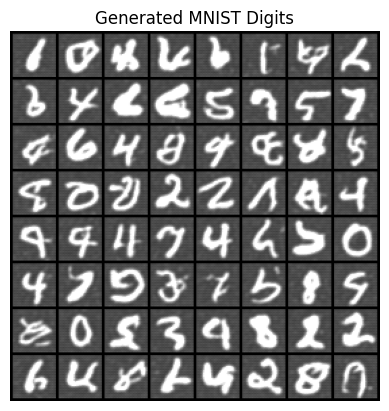

Generated images saved to mnist_ddpm_generated.png


In [9]:
# 加载数据集
transforms_ = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # 将像素值归一化到 [-1, 1]
])
dataset = datasets.MNIST('.', train=True, download=True, transform=transforms_)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
# 初始化模型和优化器
model = SimpleUnet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# 训练循环
for epoch in range(EPOCHS):
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for step, (images, _) in enumerate(loop):
        optimizer.zero_grad()

        t = torch.randint(0, TIMESTEPS, (images.shape[0],), device=DEVICE).long()
        images = images.to(DEVICE)

        loss = get_loss(model, images, t)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
# 训练完成，开始采样（生成图片）
print("Training finished. Starting sampling...")
generated_images = sample(model, IMG_SIZE, batch_size=64)

# 将图片反归一化到 [0, 1] 以便显示和保存
generated_images = (generated_images + 1) * 0.5

# 显示生成的图片
show_images(generated_images, "Generated MNIST Digits")
# 保存一张网格图
save_image(make_grid(generated_images, nrow=8), "mnist_ddpm_generated.png")
print("Generated images saved to mnist_ddpm_generated.png")